\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}
\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center}

In [1]:
from adaboost_starter_code import get_circle_data

SyntaxError: invalid syntax (adaboost_starter_code.py, line 121)

In [2]:
import scipy
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

#### These first 3 functions are free: you do not need to change them.

def find_split(X, y, wgts=None):
    """Find the best single split on one of the two variables, while incorporating weights.

    Inputs:
    X: a numpy array with 2 columns
    y: a numpy array with n elements
    wgts: a numpy array of n observation weights.

    Return two things:
    fit: The object returned by DecisionTreeClassifier
    tree_info: A dictionary with the following additional info. You don't need
    this, but it might help debug:

    variable_idx: Number of selected variable column
    threshold: Where that variable was split
    guess_less: which category is guessed if less than threshold
    guess_greater: which category is guessed if greater than threshold
    """

    n = X.shape[0]
    dtc = DecisionTreeClassifier(max_depth=1)
    fit = dtc.fit(X,y, sample_weight=wgts)
    tree_info = {
        'variable_idx' : fit.tree_.feature[0],
        'threshold' : fit.tree_.threshold[0],
        'guess_less' : np.argmax(fit.tree_.value[1])*2-1,
        'guess_greater' : np.argmax(fit.tree_.value[2])*2-1
    }

    return fit, tree_info


def draw_boosted_trees(trees, X, score=None):
    """Draw the data points and the decision boundaries used by the boosted trees.

    If score is supplied, the points are also shaded by the score.

    Inputs:
    trees: the list of tree objects output by my_adaboost
    X: a set of points output by get_circle_data (no y is needed)
    score: n-vector of scores to color each point (optional)
    Outputs: makes a plot.  You still need to call plt.show()
    """

    if score is not None:
        plt.scatter(X[:,0], X[:,1], c=score, cmap=plt.get_cmap('plasma'))
        ax = plt.axes()
        ax.set(aspect=1, xlim=(-4, 4), ylim=(-4, 4))
    else:
        plt.scatter(X[:,0], X[:,1])

    line_col='grey'

    for fit in trees:
        variable_idx = fit.tree_.feature[0]
        threshold = fit.tree_.threshold[0]

        if variable_idx == 0:
            plt.axvline(x=threshold, color=line_col)
        else:
            plt.axhline(y=threshold, color=line_col)


def get_circle_data(n):
    """Generate data for our example

    Inputs:
    n: number of samples

    Output: tuple with entries:
    X: an nx2 matrix of data points.
    y: class for the point (-1,1)
    """

    gaussian_2d = scipy.stats.multivariate_normal(mean = np.zeros(2), cov = np.eye(2))
    X = gaussian_2d.rvs(n)
    Y = np.where(X[:,0]**2 + X[:,1]**2 < 1, 1, -1)

    return X, Y

#### YOU DON'T NEED TO CHANGE FUNCTIONS ABOVE THIS LINE, THEY ARE FREE ####

#### You must finish the functions below this line ####

def my_adaboost(X, y, B=10):
    """Implement the adaboost function in my_adaboost

    Inputs:
    X, y: Data produced by get_circle_data()
    B: The number of trees to produce during boosting

    Returns:
    trees: a list of fitted tree objects
    alphas: a numpy array of B alpha values for the trees
    """

    n = X.shape[0]
    # Equal observation weights
    wgts = np.repeat(1/n, n)
    trees = [] # To store your trees.  Use append()
    alphas = np.zeros(B) # To store your alphas

    for b in range(B):
        # Find the next split, according to your current weights.
        # Hint: the returned tree supports predict()
        tree, info = find_split(X, y, wgts)
        
        misclf = (tree.predict(X) != y)
        eb = (wgts*misclf).sum()/wgts.sum()
        alpha = np.log((1-eb)/eb)
        alphas[b] = alpha# TODO: Add the new tree's weight
        trees.append(tree) # TODO: Store the new tree
        wgts *= np.exp(alpha*misclf)# TODO: Update your observation weights

    return trees, alphas

X, y = get_circle_data(1000)

my_adaboost(X, y)

([DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1)],
 array([0.38882579, 0.59771879, 0.45776461, 0.6457377 , 0.4813864 ,
        0.6654676 , 0.49588465, 0.76088568, 0.54591318, 0.66775269]))

In [1]:
def predict_ada(trees, alphas, X, y=None):
    """Calculate predictions for boosted trees from my_adaboost.

    If passed true y values, also computes *running* misclassification error
    across all B.

    Inputs:
    trees: list of trees returned by my_adaboost
    alphas: alpha vector returned by my_adaboost
    X: a data set to make predictions on
    y: the true labels for that data set, in {-1,1}.  If given, running prediction error is computed.

    Outputs: a list containing:
    score: the score for each point (before thresholding)
    preds: the thresholded scores: our guesses at class.
    test_err: a length B vector of misclassification error at each step (1 tree to B trees)
    """

    n = X.shape[0]
    B = len(trees)

    # Initialize a score vector to zero.
    # This will store the ongoing sum alpha_b fhat_b(x) for each point.
    score = np.zeros(n)

    # This will store the misclassification error at each step,
    # so we can see how it changes with the number of trees
    test_err = np.zeros(B)

    for b in range(B):
        # Update your score to include the contribution from tree b
        score += alphas[b]*trees[b].predict(X) # TODO: Fill in the updated score
        preds = np.sign(score) # TODO: Make predictions in {-1,1}

        if y is not None:
            # Record the misclassification error for the predictions
            # based on thresholding the current score
            test_err[b] = (y!=preds).mean() # TODO: Fill in the current misclassification error
            
    if y is None:
        return score, preds

    return score, preds, test_err

X, y = get_circle_data(500)
trees, alphas = my_adaboost(X, y)
# predict_ada(trees, alphas, X, y)

NameError: name 'get_circle_data' is not defined

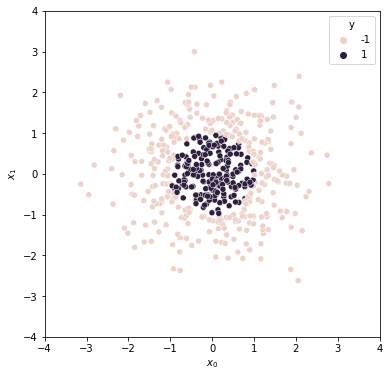

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame

X_train, y_train = get_circle_data(500)
data = DataFrame(X_train, columns=['$x_0$', '$x_1$'])
data['y'] = y_train

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = sns.scatterplot(x='$x_0$', y='$x_1$', hue='y', data=data)
ax.set(xlim=(-4, 4), ylim=(-4, 4))
plt.show()

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


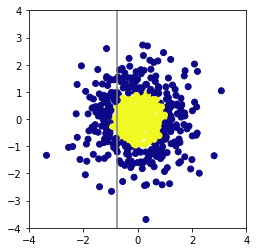

In [27]:
X_train, y_train = get_circle_data(500)
X_test, y_test = get_circle_data(500)

trees, alphas = my_adaboost(X_train, y_train, B=1)
draw_boosted_trees(trees, X_train, y_train)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


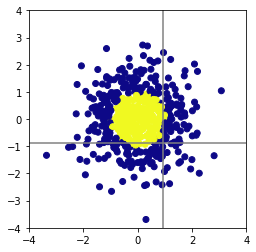

In [28]:
trees, alphas = my_adaboost(X, y, B=2)
draw_boosted_trees(trees, X_train, y_train)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


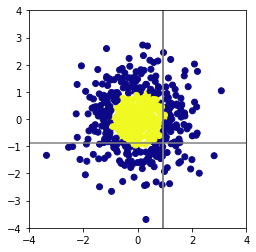

In [29]:
trees, alphas = my_adaboost(X, y, B=3)
draw_boosted_trees(trees, X_train, y_train)

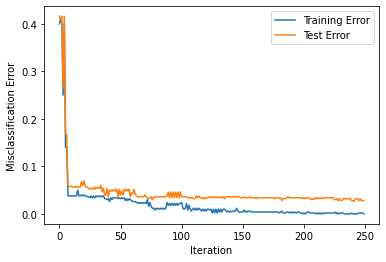

In [30]:
import matplotlib.pyplot as plt
from pandas import DataFrame

trees, alphas = my_adaboost(X_train, y_train, B=250)
err_train = predict_ada(trees, alphas, X_train, y_train)[-1]
err_test = predict_ada(trees, alphas, X_test, y_test)[-1]

pred_err = DataFrame({'Training Error': err_train, 'Test Error': err_test})
ax = pred_err.plot()
ax.set(ylabel='Misclassification Error', xlabel='Iteration')
plt.show()

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


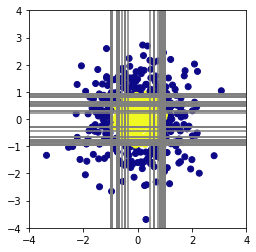

In [31]:
draw_boosted_trees(trees, X_train, y_train)

In [32]:
pred_err

,Training Error,Test Error
0,0.400,0.416
1,0.412,0.408
2,0.400,0.416
3,0.250,0.264
4,0.400,0.416
...,...,...
245,0.002,0.028
246,0.002,0.032
247,0.002,0.028
248,0.002,0.028


<AxesSubplot:>

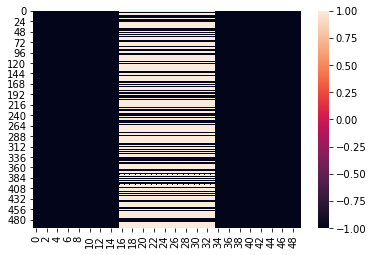

In [4]:
def calculate_partial_dependence_x1(trees, alphas, X):
    """Calculates the partial dependence plot over the first column of X.

    Fixes the first column at each point in the grid and evaluates the
    predictions at all of these fake points.  These predictions are used
    to obtain the partial dependence over x1.

    Inputs:
    trees: list of trees returned by my_adaboost
    alphas: list of alphas returned by my_adaboost
    X: data set to use for computing partial dependence.
    """

    m = 50 # Number of grid points to evaluate partial dependence
    x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), m)

    # Somewhere to store the partial dependence values
    pdep = np.zeros(m)

    res = []
    
    # We will fake a dataset and change its x1 values to match each evaluation points
    fake = X.copy()
    for i in range(m):
        fake[:,0] = x[i]
        # TODO: Fill in the actual calculation of the partial
        # dependence at x[i] below
        # HINT: Evaluate predict_ada on the fake data set and use
        # resulting predictions
#         pdep[i] = 
        res.append(predict_ada(trees, alphas, fake)[1])
        
    return x, pdep, res

from pandas import DataFrame
import numpy as np
import seaborn as sns

np.random.seed(0)

X, y = get_circle_data(500)
trees, alphas = my_adaboost(X, y)
sns.heatmap(DataFrame(calculate_partial_dependence_x1(trees, alphas, X)[2]).T)